In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# get a listing of columns and data types for the meausurement and station tables
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
print('-----------------')
print('measurement table')
print('-----------------')
for column in columns:
    print(column["name"], column["type"])
    
columns = inspector.get_columns('station')
print('-----------------')
print('station table')
print('-----------------')
for column in columns:
    print(column["name"], column["type"])

-----------------
measurement table
-----------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------------
station table
-----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Inspect the data values in the meaurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [10]:
# Inspect the data values in the station table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Prior Year Date: 2016-08-23


Text(0, 0.5, 'Inches')

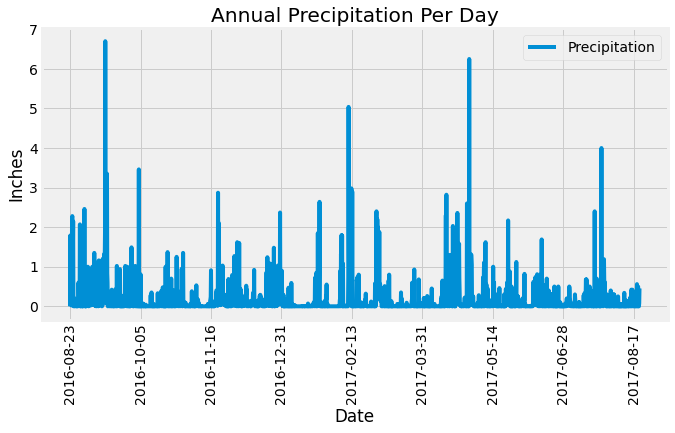

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = dt.datetime.strptime(max_date_str[0], '%Y-%m-%d')
prior_year_date = dt.date(max_date.year -1, max_date.month, max_date.day)
print(f'Prior Year Date: {prior_year_date}')

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
precipitation_query = session.query(*sel).filter(Measurement.date >= prior_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_query, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.set_index('Date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index(axis=0)

# delete null precipitation values
precipitation_df = precipitation_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(facecolor='white')
ax = precipitation_df.plot(rot=90,figsize=(10,5), ax=ax)
ax.set_title("Annual Precipitation Per Day")
ax.set_ylabel("Inches")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f'There are {station_count} stations available in the dataset.')


There are 9 stations available in the dataset.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.date).desc()).all()

for active_station in active_stations:
    print(active_station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# identify the most active station from the previous query
station_id = active_stations[0][0]

# create the select from tobs aggregations 
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
      ]
active_station_temp_stats = session.query(*sel).\
    filter(Measurement.station == station_id).all()

for temps in active_station_temp_stats:
    print(f'Station {station_id} Recorded Temps: Lowest: {temps[0]}, Highest: {temps[1]}, Average: {temps[2]}')

Station USC00519281 Recorded Temps: Lowest: 54.0, Highest: 85.0, Average: 71.66378066378067


In [18]:
# Choose the station with the highest number of temperature observations.
active_station_observations =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == station_id).\
                    filter(Measurement.date >= prior_year_date).all()

# print the prior 12 months of observations for the most active station
for observations in active_station_observations:
    print(observations)

('2016-08-23', 77.0)
('2016-08-24', 77.0)
('2016-08-25', 80.0)
('2016-08-26', 80.0)
('2016-08-27', 75.0)
('2016-08-28', 73.0)
('2016-08-29', 78.0)
('2016-08-30', 77.0)
('2016-08-31', 78.0)
('2016-09-01', 80.0)
('2016-09-02', 80.0)
('2016-09-03', 78.0)
('2016-09-04', 78.0)
('2016-09-05', 78.0)
('2016-09-06', 73.0)
('2016-09-07', 74.0)
('2016-09-08', 80.0)
('2016-09-09', 79.0)
('2016-09-10', 77.0)
('2016-09-11', 80.0)
('2016-09-12', 76.0)
('2016-09-13', 79.0)
('2016-09-14', 75.0)
('2016-09-15', 79.0)
('2016-09-16', 78.0)
('2016-09-17', 79.0)
('2016-09-18', 78.0)
('2016-09-19', 78.0)
('2016-09-20', 76.0)
('2016-09-21', 74.0)
('2016-09-22', 77.0)
('2016-09-23', 78.0)
('2016-09-24', 79.0)
('2016-09-25', 79.0)
('2016-09-26', 77.0)
('2016-09-27', 80.0)
('2016-09-28', 78.0)
('2016-09-29', 78.0)
('2016-09-30', 78.0)
('2016-10-01', 77.0)
('2016-10-02', 79.0)
('2016-10-03', 79.0)
('2016-10-04', 79.0)
('2016-10-05', 79.0)
('2016-10-06', 75.0)
('2016-10-07', 76.0)
('2016-10-08', 73.0)
('2016-10-09'

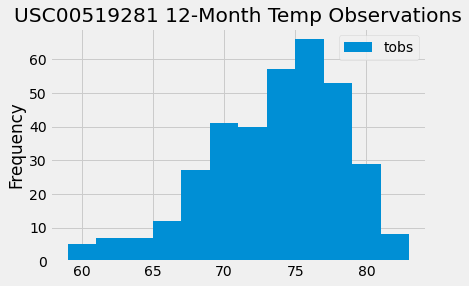

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_df= pd.DataFrame(active_station_observations)
active_station_df.plot(kind="hist",bins=12, title=f'{station_id} 12-Month Temp Observations')

## Bonus Challenge Assignment
### Temperature Analysis I
#### Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [20]:
# using sqlite and pandas for this bonus exercise
import sqlite3
# Create a SQL connection to our SQLite database
con = sqlite3.connect("Resources/hawaii.sqlite")
    
# Create query 
temp_query = "SELECT strftime('%m', date) as MONTH, tobs as TEMP from Measurement where strftime('%m', date) in ('06','12')"

# import query results into df
temp_df = pd.read_sql(temp_query, con)

# make the month values eaiser to interpret
temp_df['MONTH'] = temp_df['MONTH'].replace(['06'],'June')
temp_df['MONTH'] = temp_df['MONTH'].replace(['12'],'December')

# display the avg for each month
temp_group_df = temp_df.groupby(by=['MONTH']).mean()
temp_group_df = temp_group_df.rename(columns={"TEMP":"AVG TEMP"})
temp_group_df

,AVG TEMP
MONTH,
December,71.041529
June,74.944118


In [21]:
# perfrom the ttest with scipy
from scipy.stats import ttest_ind

# create June and December series
June = temp_df[temp_df['MONTH']=='June']
December = temp_df[temp_df['MONTH']=='December']

# perform the ttest against the June and December series
ttest_results = ttest_ind(June['TEMP'], December['TEMP'])

print(ttest_results)

# determine if their is a statistical significance
p_value = ttest_results[1]

if p_value < 0.05:
    print(f'A P-Value of {p_value} is statistically significant.')    
else:
    print(f'A P-Value of {p_value} is not statistically significant.')   
    

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)
A P-Value of 3.9025129038616655e-191 is statistically significant.


## Bonus Challenge Assignment
### Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# choose 2017 dates for vacation
vacation_start = dt.datetime.strptime('2017-11-01', '%Y-%m-%d')
vacation_end = dt.datetime.strptime('2017-11-07', '%Y-%m-%d') 

# determine the vacation dates from one year ago
prior_year_start = dt.date(vacation_start.year -1, vacation_start.month, vacation_start.day)
prior_end_start = dt.date(vacation_end.year -1, vacation_end.month, vacation_end.day)

calc_temp_results = calc_temps(prior_year_start, prior_end_start)

# create a df to hold the data
columns = ['TMIN','TAVE','TMAX']
calc_temp_df = pd.DataFrame(calc_temp_results,columns = columns)
calc_temp_df

,TMIN,TAVE,TMAX
0,63.0,75.0,79.0


Text(0, 0.5, 'Temp (F)')

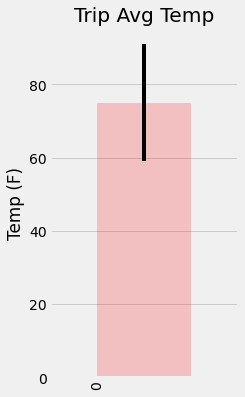

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_error = [calc_temp_df['TMAX']- calc_temp_df['TMIN']]


ax2 =calc_temp_df.plot(kind='bar', y='TAVE', 
                  yerr=y_error, 
                  color='red', 
                  alpha=0.2,
                  legend = '',
                  figsize=(3,6), 
                  title='Trip Avg Temp',
                  align='edge'
                 )

plt.grid(which='major', axis='x', linestyle='')
plt.ylabel("Temp (F)")


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.tobs)]

rainfall_query = session.query(*rainfall_sel).\
                 group_by(Measurement.station).\
                 outerjoin(Station, Measurement.station == Station.station).\
                 filter(Measurement.date >= prior_year_start).\
                 filter(Measurement.date <= prior_end_start).\
                 order_by(func.sum(Measurement.tobs).desc()).all()

for station in rainfall_query:
    print(station)



('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 540.0)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 536.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 530.0)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 520.0)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 514.0)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 508.0)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 152.0)


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
trip_dates = []

# Set the start and end date of the trip
trip_start = vacation_start
trip_end = vacation_end

# Use the start and end date to create a range of dates
trip_timedelta = (trip_end - trip_start)
trip_length_days = (trip_timedelta.days + 1)

# Loop through the list of %m-%d strings and calculate the normals for each date
for i in range(trip_length_days):
    trip_day = trip_start + dt.timedelta(days=i)
    # Strip off the year and save a list of %m-%d strings
    cleaned_day = dt.datetime.strftime(trip_day,'%m-%d')
    trip_dates.append(cleaned_day)
    normals.append(daily_normals(cleaned_day)[0])

normals

[(65.0, 74.86274509803921, 83.0),
 (64.0, 74.0625, 81.0),
 (66.0, 74.95918367346938, 82.0),
 (65.0, 74.0754716981132, 82.0),
 (64.0, 73.5576923076923, 78.0),
 (66.0, 74.31111111111112, 81.0),
 (63.0, 73.76, 80.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = pd.DataFrame(normals, index=trip_dates, columns = ['TMIN' , 'TAVG', 'TMAX']) 
trip_normals_df.index.name = "Vacation Date"
trip_normals_df

,TMIN,TAVG,TMAX
Vacation Date,,,
11-01,65.0,74.862745,83.0
11-02,64.0,74.062500,81.0
11-03,66.0,74.959184,82.0
11-04,65.0,74.075472,82.0
11-05,64.0,73.557692,78.0
11-06,66.0,74.311111,81.0
11-07,63.0,73.760000,80.0


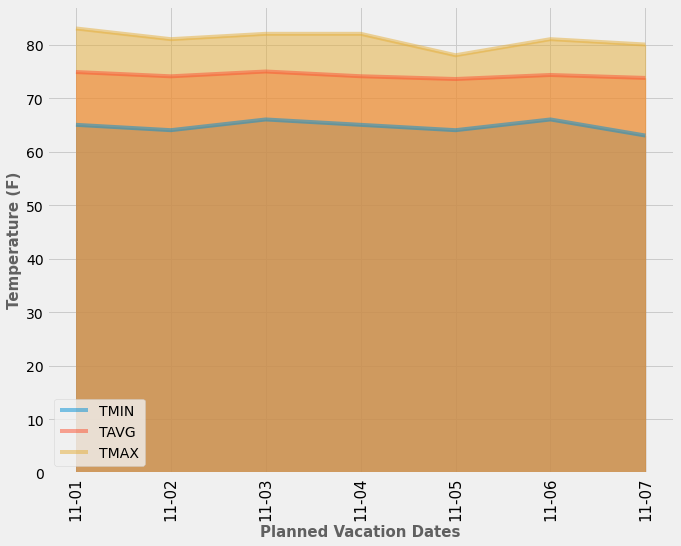

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot.area(stacked=False, figsize=(10, 8))
plt.legend(('TMIN', 'TAVG', 'TMAX'),loc='lower left')
plt.xlabel('Planned Vacation Dates',fontweight="bold", alpha=0.6, fontsize=15)
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.6, fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.show()

In [30]:
#session.close()